In [2]:
!pip install fair-esm

In [3]:
import pandas as pd
df=pd.read_csv('/kaggle/input/gfp-set/classified_proteins_output.csv')
print(len(df))
df

354


/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,Name,Ex max (nm),Em max (nm),Stokes Shift (nm),Extinction Coefficient,Quantum Yield,Brightness,pKa,Oligomerization,Maturation (min),Lifetime (ns),Molecular Weight (kDa),Switch Type,Aliases,Sequence,Sequence_Clean,Cluster,Color
0,mStayGold2,499.0,509.0,10.0,175000,0.79,138.25,4.80,m,NaN,2.83,26.49,b,QC2-6(PT),MVSTGEELFTGVVPFKFQLKGTINGKSFTVEGEGEGNSHEGSHKGK...,MVSTGEELFTGVVPFKFQLKGTINGKSFTVEGEGEGNSHEGSHKGK...,0,Cyan/Green
1,mStayGold,499.0,510.0,11.0,164000,0.83,136.12,4.80,m,NaN,2.79,25.58,b,QC2-6 FIQ,MVSTGEELFTGVVPFKFQLKGTINGKSFTVEGEGEGNSHEGSHKGK...,MVSTGEELFTGVVPFKFQLKGTINGKSFTVEGEGEGNSHEGSHKGK...,0,Cyan/Green
2,StayGold-E138D,497.0,504.0,7.0,145000,0.87,126.15,4.60,m,14.0,NaN,24.60,b,mStayGold,MASTPFKFQLKGTINGKSFTVEGEGEGNSHEGSHKGKYVCTSGKLP...,MASTPFKFQLKGTINGKSFTVEGEGEGNSHEGSHKGKYVCTSGKLP...,0,Cyan/Green
3,mBaoJin,500.0,508.0,8.0,128000,0.93,119.04,4.37,m,7.6,3.10,26.58,b,"mBJ, mStayGold",MVSKGEEENMASTPFKFQLKGTINGKSFTVEGEGEGNSHEGSHKGK...,MVSKGEEENMASTPFKFQLKGTINGKSFTVEGEGEGNSHEGSHKGK...,0,Green/Yellow
4,mBaoJin-T55S,497.0,508.0,11.0,127000,0.86,109.22,NaN,m,NaN,NaN,26.56,b,mBJ-T55S,MVSKGEEENMASTPFKFQLKGTINGKSFTVEGEGEGNSHEGSHKGK...,MVSKGEEENMASTPFKFQLKGTINGKSFTVEGEGEGNSHEGSHKGK...,0,Cyan/Green
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
349,ShG24,486.0,506.0,20.0,-,NaN,NaN,NaN,m,NaN,NaN,26.96,b,NaN,MSKGEELFTGVVPILVELDGDVHGHKFSVRGEGEGDADYGKLEIKF...,MSKGEELFTGVVPILVELDGDVHGHKFSVRGEGEGDADYGKLEIKF...,0,Cyan/Green
350,Slow-FT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,m,NaN,NaN,26.79,t,NaN,MVSKGEEDNMAIIKEFMRFKVHVEGSVNGHEFEIVGEGEGRPYEGT...,MVSKGEEDNMAIIKEFMRFKVHVEGSVNGHEFEIVGEGEGRPYEGT...,0,Unknown
351,SuperfoldermTurquoise2,434.0,474.0,40.0,-,NaN,NaN,NaN,m,NaN,NaN,26.85,b,sfTq2,MVSKGEELFT GVVPILVELD GDVNGHKFSV RGEGEGDATN GK...,MVSKGEELFTGVVPILVELDGDVNGHKFSVRGEGEGDATNGKLTLK...,0,Blue/Cyan
352,SuperfoldermTurquoise2ox,434.0,474.0,40.0,-,NaN,NaN,NaN,m,NaN,NaN,26.84,b,sfTq2ox,MVSKGEELFT GVVPILVELD GDVNGHKFSV RGEGEGDATN GK...,MVSKGEELFTGVVPILVELDGDVNGHKFSVRGEGEGDATNGKLTLK...,0,Blue/Cyan


In [4]:
import torch 
from torch import nn
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torch.cuda.amp import autocast, GradScaler
from torch.nn.functional import cross_entropy, mse_loss, cosine_similarity
import esm
from tqdm import tqdm
from torch.nn.utils.rnn import pad_sequence
# ── Config ──
MAX_LEN       = 512
BATCH_SIZE    = 64
LATENT_DIM    = 256
EMB_DIM       = 256
NUM_LAYERS    = 4
NUM_HEADS     = 4
FFN_DIM       = 512
DROPOUT       = 0.3

LR_PHASE1     = 5e-4    # higher LR for CE‐only warmup
LR_PHASE2     = 1e-4    # later LR

EPOCHS_PHASE1 = 100      # CE‐only for first 20 epochs
TOTAL_EPOCHS  = 500

CE_WEIGHT1    = 100.0    # CE weight during phase1
CE_WEIGHT2    = 1.0     # CE weight afterwards
KL_WEIGHT     = 0.1
COS_WEIGHT    = 5.0
MSE_WEIGHT    = 5.0
class SequenceDataset(Dataset):
    def __init__(self, seqs, alphabet, max_len=MAX_LEN):
        self.seqs     = seqs
        self.alphabet = alphabet
        self.max_len  = max_len

    def __len__(self):
        return len(self.seqs)

    def __getitem__(self, idx):
        seq = self.seqs[idx][:self.max_len]
        ids = [self.alphabet.get_idx(c) for c in seq]
        return torch.tensor(ids, dtype=torch.long)

def collate_fn(batch):
    # pad to max length in batch
    lengths = [len(x) for x in batch]
    L = max(lengths)
    padded = torch.full((len(batch), L), PAD_IDX, dtype=torch.long)
    mask   = torch.zeros(len(batch), L, dtype=torch.bool)
    for i, x in enumerate(batch):
        padded[i, :len(x)] = x
        mask[i, :len(x)]   = True
    return padded.to(DEVICE), mask.to(DEVICE)
import torch 
from torch import nn
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torch.cuda.amp import autocast, GradScaler
from torch.nn.functional import cross_entropy, mse_loss, cosine_similarity
import esm
from tqdm import tqdm
from torch.nn.utils.rnn import pad_sequence

# ── Config ──
MAX_LEN       = 512
BATCH_SIZE    = 64
LATENT_DIM    = 256
EMB_DIM       = 256
NUM_LAYERS    = 4
NUM_HEADS     = 4
FFN_DIM       = 512
DROPOUT       = 0.3

LR_PHASE1     = 5e-4    # higher LR for CE‐only warmup
LR_PHASE2     = 1e-4    # later LR

EPOCHS_PHASE1 = 100      # CE‐only for first 20 epochs
TOTAL_EPOCHS  = 500

CE_WEIGHT1    = 100.0    # CE weight during phase1
CE_WEIGHT2    = 1.0     # CE weight afterwards
KL_WEIGHT     = 0.1
COS_WEIGHT    = 5.0
MSE_WEIGHT    = 5.0

class ProteinDataset(Dataset):
    def __init__(self, sequences, alphabet):
        self.sequences = [seq[:MAX_LEN] for seq in sequences]
        self.alphabet  = alphabet

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        idxs = [self.alphabet.get_idx(c) for c in self.sequences[idx]]
        return torch.tensor(idxs, dtype=torch.long)

def collate_fn(batch, pad_idx):
    padded = pad_sequence(batch, batch_first=True, padding_value=pad_idx)
    mask   = (padded != pad_idx)
    return padded, mask
    
class SmallTransformer(nn.Module):
    def __init__(self, vocab_size, emb_dim, layers, heads, ffn_dim, max_len, pad_idx):
        super().__init__()
        self.emb = nn.Embedding(vocab_size, emb_dim, padding_idx=pad_idx)
        self.pos = nn.Parameter(torch.zeros(1, max_len, emb_dim))
        layer   = nn.TransformerEncoderLayer(
            d_model=emb_dim, nhead=heads,
            dim_feedforward=ffn_dim, batch_first=True,
            activation='gelu', dropout=DROPOUT
        )
        self.enc = nn.TransformerEncoder(layer, layers)
        self.ln  = nn.LayerNorm(emb_dim)

    def forward(self, x):
        mask = x != self.emb.padding_idx
        h    = self.emb(x) + self.pos[:, :x.size(1), :]
        h    = self.enc(h, src_key_padding_mask=~mask)
        return self.ln(h), mask

class BigTransformer(SmallTransformer):
    pass  # identical API

# ── Single‐stage VAE ──
class VAETransformerDecoder(nn.Module):
    def __init__(self, encoder, vocab_size, latent_dim=LATENT_DIM,
                 emb_dim=EMB_DIM, num_layers=NUM_LAYERS, num_heads=NUM_HEADS,
                 ffn_dim=FFN_DIM, max_len=MAX_LEN, pad_token=0, bos_token=1):
        super().__init__()
        self.encoder   = encoder
        self.pad_token = pad_token
        self.bos_token = bos_token

        # latent heads
        self.to_mu     = nn.Linear(emb_dim, latent_dim)
        self.to_logvar = nn.Linear(emb_dim, latent_dim)
        self.latent2emb= nn.Linear(latent_dim, emb_dim)

        # decoder
        self.dec_emb = nn.Embedding(vocab_size, emb_dim, padding_idx=pad_token)
        self.dec_pos = nn.Parameter(torch.zeros(1, max_len, emb_dim))
        layer = nn.TransformerDecoderLayer(
            d_model=emb_dim, nhead=num_heads,
            dim_feedforward=ffn_dim, dropout=DROPOUT,
            batch_first=True
        )
        self.decoder = nn.TransformerDecoder(layer, num_layers)
        self.out     = nn.Linear(emb_dim, vocab_size)

    def forward(self, x, mask):
        # encode
        h_enc, enc_mask = self.encoder(x)
        pooled = (h_enc * enc_mask.unsqueeze(-1)).sum(1) / enc_mask.sum(1, True)
        mu, logvar = self.to_mu(pooled), self.to_logvar(pooled)
        z = mu + torch.randn_like(mu) * torch.exp(0.5 * logvar)

        # prepare decoder input
        B, L = x.size()
        dec_in = torch.full((B, L), self.bos_token, device=x.device, dtype=torch.long)
        dec_in[:,1:] = x[:,:-1]
        emb = self.dec_emb(dec_in) + self.dec_pos[:, :L, :]
        z_emb = self.latent2emb(z).unsqueeze(1).expand(-1, L, -1)
        emb = emb + z_emb

        tgt_mask = nn.Transformer.generate_square_subsequent_mask(L).to(x.device)
        h_dec = self.decoder(
            tgt=emb,
            memory=h_enc,
            tgt_mask=tgt_mask,
            tgt_key_padding_mask=~mask,
            memory_key_padding_mask=~enc_mask
        )
        logits = self.out(h_dec)
        return logits, mu, logvar, h_enc, enc_mask

# load alphabet & teacher
import esm
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
_, alphabet = esm.pretrained.esm2_t33_650M_UR50D()
PAD_IDX     = alphabet.get_idx('<pad>')
BOS_IDX     = alphabet.get_idx('<cls>')
enc = BigTransformer(
        len(alphabet.all_toks), EMB_DIM, NUM_LAYERS, NUM_HEADS, FFN_DIM, MAX_LEN, PAD_IDX
    ).to(device)
vae = VAETransformerDecoder(
        encoder=enc,
        vocab_size=len(alphabet.all_toks),
        latent_dim=LATENT_DIM,
        emb_dim=EMB_DIM, num_layers=NUM_LAYERS, num_heads=NUM_HEADS,
        ffn_dim=FFN_DIM, max_len=MAX_LEN,
        pad_token=PAD_IDX, bos_token=BOS_IDX
    ).to(device)
#vae = nn.DataParallel(vae)
# ── 0) Config ──
device      = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
CHECKPOINT  = "/kaggle/input/esms-vae/pytorch/default2/1/vae_epoch380.pt"
noise_scale = 0.2   # tweak as needed
ckpt = torch.load(CHECKPOINT, map_location=device)
vae.load_state_dict(ckpt["model_sd"])
vae.to(device).eval()
print('loaded vae')

Downloading: "https://dl.fbaipublicfiles.com/fair-esm/models/esm2_t33_650M_UR50D.pt" to /root/.cache/torch/hub/checkpoints/esm2_t33_650M_UR50D.pt
Downloading: "https://dl.fbaipublicfiles.com/fair-esm/regression/esm2_t33_650M_UR50D-contact-regression.pt" to /root/.cache/torch/hub/checkpoints/esm2_t33_650M_UR50D-contact-regression.pt


loaded vae


In [5]:
vae_module=vae.eval().to(device)

In [6]:
import pandas as pd
df=pd.read_csv('/kaggle/input/gfp-set/classified_proteins_output.csv')
df

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,Name,Ex max (nm),Em max (nm),Stokes Shift (nm),Extinction Coefficient,Quantum Yield,Brightness,pKa,Oligomerization,Maturation (min),Lifetime (ns),Molecular Weight (kDa),Switch Type,Aliases,Sequence,Sequence_Clean,Cluster,Color
0,mStayGold2,499.0,509.0,10.0,175000,0.79,138.25,4.80,m,NaN,2.83,26.49,b,QC2-6(PT),MVSTGEELFTGVVPFKFQLKGTINGKSFTVEGEGEGNSHEGSHKGK...,MVSTGEELFTGVVPFKFQLKGTINGKSFTVEGEGEGNSHEGSHKGK...,0,Cyan/Green
1,mStayGold,499.0,510.0,11.0,164000,0.83,136.12,4.80,m,NaN,2.79,25.58,b,QC2-6 FIQ,MVSTGEELFTGVVPFKFQLKGTINGKSFTVEGEGEGNSHEGSHKGK...,MVSTGEELFTGVVPFKFQLKGTINGKSFTVEGEGEGNSHEGSHKGK...,0,Cyan/Green
2,StayGold-E138D,497.0,504.0,7.0,145000,0.87,126.15,4.60,m,14.0,NaN,24.60,b,mStayGold,MASTPFKFQLKGTINGKSFTVEGEGEGNSHEGSHKGKYVCTSGKLP...,MASTPFKFQLKGTINGKSFTVEGEGEGNSHEGSHKGKYVCTSGKLP...,0,Cyan/Green
3,mBaoJin,500.0,508.0,8.0,128000,0.93,119.04,4.37,m,7.6,3.10,26.58,b,"mBJ, mStayGold",MVSKGEEENMASTPFKFQLKGTINGKSFTVEGEGEGNSHEGSHKGK...,MVSKGEEENMASTPFKFQLKGTINGKSFTVEGEGEGNSHEGSHKGK...,0,Green/Yellow
4,mBaoJin-T55S,497.0,508.0,11.0,127000,0.86,109.22,NaN,m,NaN,NaN,26.56,b,mBJ-T55S,MVSKGEEENMASTPFKFQLKGTINGKSFTVEGEGEGNSHEGSHKGK...,MVSKGEEENMASTPFKFQLKGTINGKSFTVEGEGEGNSHEGSHKGK...,0,Cyan/Green
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
349,ShG24,486.0,506.0,20.0,-,NaN,NaN,NaN,m,NaN,NaN,26.96,b,NaN,MSKGEELFTGVVPILVELDGDVHGHKFSVRGEGEGDADYGKLEIKF...,MSKGEELFTGVVPILVELDGDVHGHKFSVRGEGEGDADYGKLEIKF...,0,Cyan/Green
350,Slow-FT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,m,NaN,NaN,26.79,t,NaN,MVSKGEEDNMAIIKEFMRFKVHVEGSVNGHEFEIVGEGEGRPYEGT...,MVSKGEEDNMAIIKEFMRFKVHVEGSVNGHEFEIVGEGEGRPYEGT...,0,Unknown
351,SuperfoldermTurquoise2,434.0,474.0,40.0,-,NaN,NaN,NaN,m,NaN,NaN,26.85,b,sfTq2,MVSKGEELFT GVVPILVELD GDVNGHKFSV RGEGEGDATN GK...,MVSKGEELFTGVVPILVELDGDVNGHKFSVRGEGEGDATNGKLTLK...,0,Blue/Cyan
352,SuperfoldermTurquoise2ox,434.0,474.0,40.0,-,NaN,NaN,NaN,m,NaN,NaN,26.84,b,sfTq2ox,MVSKGEELFT GVVPILVELD GDVNGHKFSV RGEGEGDATN GK...,MVSKGEELFTGVVPILVELDGDVNGHKFSVRGEGEGDATNGKLTLK...,0,Blue/Cyan


In [7]:
DEVICE=device

In [8]:
def generate_from_z(z, max_len=MAX_LEN):
    """
    Autoregressively decode latent vectors z into sequences.
    z: FloatTensor of shape (B, latent_dim)
    Returns list of B strings.
    """
    batch = z.size(0)
    # initialize with PAD, then BOS at first position
    generated = torch.full((batch, max_len), PAD_IDX, device=DEVICE, dtype=torch.long)
    generated[:, 0] = BOS_IDX

    # causal mask for transformer decoder
    tgt_mask = torch.triu(torch.full((max_len, max_len), float('-inf')), diagonal=1).to(DEVICE)

    # dummy memory (we're decoding purely from latent)
    EMB_DIM = vae_module.dec_emb.embedding_dim
    memory  = torch.zeros(batch, max_len, EMB_DIM, device=DEVICE)

    with torch.no_grad():
        for t in range(1, max_len):
            tok_emb = vae_module.dec_emb(generated[:, :t])                        # (B, t, E)
            pos_emb = vae_module.dec_pos[:, :t, :]                                # (1, t, E)
            z_emb   = vae_module.latent2emb(z).unsqueeze(1).expand(-1, t, -1)      # (B, t, E)
            tgt     = tok_emb + pos_emb + z_emb                                   # (B, t, E)

            dec_out = vae_module.decoder(
                tgt=tgt,
                memory=memory,
                tgt_mask=tgt_mask[:t, :t],
                memory_key_padding_mask=None,
                tgt_key_padding_mask=None
            )  # (B, t, E)

            logits     = vae_module.out(dec_out)                                  # (B, t, V)
            next_token = logits[:, -1].argmax(-1)                                 # (B,)
            generated[:, t] = next_token

            # if all batches predict PAD, stop early
            if (next_token == PAD_IDX).all():
                break

    # convert token indices to strings
    out_seqs = []
    for seq in generated.cpu().tolist():
        toks = [alphabet.all_toks[i] for i in seq if i not in (PAD_IDX, BOS_IDX)]
        out_seqs.append("".join(toks))
    return out_seqs
import torch
import numpy as np
from torch.utils.data import DataLoader

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
PAD_IDX = alphabet.get_idx('<pad>')
BOS_IDX = alphabet.get_idx('<cls>')
MASK_IDX= PAD_IDX  # 또는 별도 MASK token이 있다면 그 인덱스로

def impute_X_with_vae(seqs):
    """
    seqs: list of strings, may contain 'X'
    returns: list of strings with 'X' replaced by VAE reconstruction
    """
    # 1) 토큰화 + mask 처리
    ids = []
    mask_positions = []
    for seq in seqs:
        tok_ids = []
        mask_pos = []
        for i, c in enumerate(seq):
            if c == 'X':
                tok_ids.append(MASK_IDX)
                mask_pos.append(i)
            else:
                tok_ids.append(alphabet.get_idx(c))
        ids.append(torch.tensor(tok_ids, dtype=torch.long))
        mask_positions.append(mask_pos)

    # 2) 배치패딩
    L = max(len(x) for x in ids)
    batch = torch.full((len(ids), L), PAD_IDX, dtype=torch.long, device=DEVICE)
    key_mask = batch != PAD_IDX
    for i, x in enumerate(ids):
        batch[i,:len(x)] = x.to(DEVICE)

    # 3) VAE 순전파
    with torch.no_grad():
        logits, mu, logvar, h_enc, enc_mask = vae(batch, key_mask)
        # logits: (B, L, V)

    # 4) impute
    out_seqs = []
    for i, seq in enumerate(seqs):
        pred = logits[i]             # (L, V)
        argmax_ids = pred.argmax(-1) # (L,)
        out = []
        for j, c in enumerate(seq):
            if c == 'X':
                aa = alphabet.all_toks[argmax_ids[j].item()]
            else:
                aa = c
            out.append(aa)
        out_seqs.append(''.join(out))
    return out_seqs


In [9]:
def collate_fn(batch):
    L = max(len(x) for x in batch)
    pad = torch.full((len(batch), L), PAD_IDX, dtype=torch.long)
    mask = torch.zeros(len(batch), L, dtype=torch.bool)
    for i, x in enumerate(batch):
        pad[i, :len(x)] = x
        mask[i, :len(x)] = True
    return pad.to(DEVICE), mask.to(DEVICE)

In [10]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from torch.utils.data import Dataset, DataLoader
import esm

# ── Configuration ──
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
MAX_LEN   = 512      # your previously computed average length
BATCH_SIZE = 64

# Load alphabet for tokenization
_, alphabet = esm.pretrained.esm2_t33_650M_UR50D()
PAD_IDX = alphabet.get_idx('<pad>')
gfp_seqs = df['Sequence_Clean'].tolist()
lengths = [len(s) for s in gfp_seqs]
avg_len = int(sum(lengths) / len(lengths))
print(f"Average sequence length: {avg_len}")
ds  = SequenceDataset(gfp_seqs, alphabet)
ld  = DataLoader(ds, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

# ── Dataset ──
# 1) 제공된 서열들로부터 평균 길이 계산
lengths = [len(s) for s in gfp_seqs]
#avg_len = int(sum(lengths) / len(lengths))
#print(f"Average sequence length: {avg_len}")

# 2) Dataset에서 max_len을 avg_len로 설정
class SequenceDataset(Dataset):
    def __init__(self, seqs, alphabet, max_len=avg_len):
        self.seqs     = seqs
        self.alphabet = alphabet
        self.max_len  = max_len  # now avg_len

    def __len__(self):
        return len(self.seqs)

    def __getitem__(self, idx):
        seq = self.seqs[idx]
        # ① 길면 자르고, ② 짧으면 그대로
        seq = seq[:self.max_len]
        ids = [self.alphabet.get_idx(c) for c in seq]
        return torch.tensor(ids, dtype=torch.long)




# ── Encoder & VAE ──
vae_module = vae.eval().to(DEVICE)  # unwrap DataParallel

def encode_batch(x):
    # mask = x != PAD_IDX  # internal encoder handles mask
    h_enc, _ = vae_module.encoder(x)         # (B, L, E)
    mask     = (x != PAD_IDX).unsqueeze(-1)
    pooled   = (h_enc * mask).sum(1) / mask.sum(1)  # (B, E)
    mu       = vae_module.to_mu(pooled)            # (B, latent_dim)
    return mu

# ── Collect all latents ──

all_z = []
with torch.no_grad():
    for x, _ in ld:
        all_z.append(encode_batch(x))
z_all = torch.cat(all_z, dim=0).cpu().numpy()  # shape (N, latent_dim)

Average sequence length: 234


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:508: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. We recommend specifying layout=torch.jagged when constructing a nested tensor, as this layout receives active development, has better operator coverage, and works with torch.compile. (Triggered internally at /pytorch/aten/src/ATen/NestedTensorImpl.cpp:178.)
  output = torch._nested_tensor_from_mask(


In [11]:
import numpy as np
from sklearn.cluster import KMeans

# Assuming:
# - gfp_seqs: list of sequences
# - z_all: numpy array (N, latent_dim)

# 1) Cluster
n_clusters = 3
km = KMeans(n_clusters=n_clusters, random_state=0).fit(z_all)
labels = km.labels_

# 2) Compute stats
cluster_stats = {}
cluster_truncated = {}
for cid in range(n_clusters):
    seqs = [gfp_seqs[i] for i in range(len(gfp_seqs)) if labels[i] == cid]
    lengths = np.array([len(s) for s in seqs])
    mean_len = int(lengths.mean())
    std_len = float(lengths.std(ddof=1))
    cluster_stats[cid] = (mean_len, std_len)
    truncated = [s[:mean_len] for s in seqs]
    cluster_truncated[cid] = truncated

# 3) Display
for cid, (mean_len, std) in cluster_stats.items():
    print(f"Cluster {cid}: mean length = {mean_len}, std = {std:.2f}, n = {len(cluster_truncated[cid])}")
    print(" Examples:", cluster_truncated[cid][:3], "\n")


Cluster 0: mean length = 317, std = 9.22, n = 24
 Examples: ['MSKGEELFTGVVPILVELDGDVNGHKFSVRGEGEGDATNGKLTLKFICTTGKLPVPWPTLVTTLTYGVQCFSRYPDHMKRHDFFKSAMPEGYVQERTISFKDDGTYKTRAEVKFEGDTLVNRIELKGIDFKEDGNILGHKLEYNFNSHNVYITADKQKNGIKANFKIRHNVEDGSVQLADHYQQNTPIGDGPVLLPDNHYLSTQSVLSKDPNEKRDHMVLLEFVTAAGITHGMDELYKAQVQLVESGGALVQPGGSLRLSCAASGFPVNRYSMRWYRQAPGKEREWVAGMSSAGDRSSYEDSVKGRFTISRDDARNT', 'MARKVDLTSCDREPIHIPGSIQPCGCLLACDAQAVRITRITENAGAFFGRETPRVGELLADYFGETEAHALRNALAQSSDPKRPALIFGWRDGLTGRTFDISLHRHDGTSIIEFEPAAAEQADNPLRLTRQIIARTKELKSLEEMAARVPRYLQAMLGYHRVMLYRFADDGSGMVIGEAKRSDLESFLGQHFPASLVPQQARLLYLKNAIRVVSDSRGISSRIVPEHDASGAALDLSFAHLRSISPCHLEFLRNMGVSASMSLSIIIDGTLWGLIICHHYEPRAVPMAQRVAAKRFAERLSTHFTAAHHQR', 'MAEGSVARQPDLLTCDDEPIHIPGAIQPHGLLLALAADMTIVAGSDNLPELTGLAIGALIGRSAADVFDSETHNRLTIALAEPGAAVGAPITVGFTMRKDAGFIGSWHRHDQLIFLELEPPQRDVAEPQAFFRRTNSAIRRLQAAETLESACAAAAQEVRKITGFDRVMIYRFASDFSGEVIAEDRCAEVESKLGLHYPASTVPAQARRLYTINPVRIIPDINYRPVPVTPDLNPVTGRPIDLSFAILRSVSPCHLEFMRNIGMHGTMSISILRGERLWGLIVCHHRTPYYVDLDGRQACKR

/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [28]:
cluster=0


def seq_identity(a, b):
    L = max(len(a), len(b))
    a2, b2 = a.ljust(L, '-'), b.ljust(L, '-')
    return sum(x==y for x,y in zip(a2, b2)) / L
gen_seqs=cluster_truncated[cluster]
threshold = 0.99
novel_high = []
for s in gen_seqs:
    # find best match in originals
    best_iden = max(seq_identity(s, o) for o in gfp_seqs)
    if best_iden < threshold:
        if best_iden>0.8:
            print(f'identity:{best_iden}')
            print(s)
        novel_high.append(s)

print(f"{len(novel_high)}/{len(gen_seqs)} sequences have <{threshold*100:.0f}% identity to any existing GFP.")


identity:0.9875
MSVPLTTSAFGHAFLANCEREQIHLAGSIQPHGILLAVKEPDNVVIQASINAAEFLNTNSVVGRPLRDLGGDLPLQILPHLNGPLHLAPMTLRCTVGSPPRRVDCTIHRPSNGGLIVELEPATKTTNIAPALDGAFHRITSSSSLMGLCDETATIIREITGYDRVMVVRFDEEGNGEILSERRRADLEAFLGNRYPASTIPQIARRLYEHNRVRLLVDVNYTPVPLQPRISPLNGRDLDMSLSCLRSMSPIHQKYMQDMGVGATLVCSLMVSGRLWGLIACHHYEPRFVPFHIRAAGEALAETCAIRIATLESFAQ
identity:0.9844236760124611
MARDPLPFFPPLYLGGPEITTENCEREPIHIPGSIQPHGALLTADGHSGEVLQVSLNAATFLGQEPTVLRGQTLAALLPEQWPALQAALPPGCPDALQYRATLDWPAAGHLSLTVHRVAELLILEFEPTEAWDSIGPHALRNAMFALESAPNLRALAEVATQTVRELTGFDRVMLYKFAPDATGEMIAEARREGMQAFLGHRFPASHTPAQARALYTRHLLRLTADTRAAAVPLDPVLNPQTNAPTPLGGAVLRATSPMHMQYLRNMGVGSSLSVSVVVGGQLWGLIVCHHQTPYVLPPDLRTTLEELGRKLSGQV
identity:0.9432835820895522
MASMTGGQQMGRGSMSRDPLPFFPPLYLGGPEITTENCEREPIHIPGSIQPHGALLTADGHSGEVLQMSLNAATFLGQEPTVLRGQTLAALLPEQWPALQAALPPGCPDALQYRATLDWPAAGHLSLTVHRVGELLILEFEPTEAWDSTGPHALRNAMSALESAPNLRALAEVATQTVRELTGFDRVMLYKFAPDATGEVIAEARREGLHAFLGHRFPASHIPAQARALYTRHLLRLTADTRAAAVPLDPVLNPQTNAPTPLGGAVLRATSPMHMQFLRNMGVGSSLSVSVVVG

In [22]:
def seq_identity(a, b):
    L = max(len(a), len(b))
    a2, b2 = a.ljust(L, '-'), b.ljust(L, '-')
    return sum(x==y for x,y in zip(a2, b2)) / L
novel ={}
for i in range(3):
    for s in cluster_truncated[i]:
        # find best match in originals
        best_iden = max(seq_identity(s, o) for o in gfp_seqs)
        if best_iden<0.99:
            novel[s]=[i,best_iden]

In [23]:
import torch
import joblib
import numpy as np
from torch.utils.data import Dataset, DataLoader

# ── 0. 설정 ──
DEVICE   = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
MAX_LEN  = 512
PAD_IDX  = alphabet.get_idx('<pad>')
BOS_IDX  = alphabet.get_idx('<cls>')
BATCH    = 32

# ── 1. VAE 인코더 로드 ──
# (여기서는 vae 클래스를 이미 정의했다고 가정)
vae = vae                     # VAE 모델 클래스 생성자 호출
#vae.encoder.load_state_dict(torch.load('/kaggle/input/fp_regressor/scikitlearn/default/1/saved_models/vae_encoder.pth', map_location=DEVICE))
vae = vae.to(DEVICE).eval()

# ── 2. GP 모델 로드 ──
gpc     = joblib.load('/kaggle/input/fp_regressor/scikitlearn/default/1/saved_models/gpc_fluorescence.pkl')
gpr_abs = joblib.load('/kaggle/input/fp_regressor/scikitlearn/default/1/saved_models/gpr_absorption.pkl')
gpr_em  = joblib.load('/kaggle/input/fp_regressor/scikitlearn/default/1/saved_models/gpr_emission.pkl')

# ── 3. 예측용 유틸 함수 ──
class PredictDataset(Dataset):
    def __init__(self, seqs, alphabet):
        self.seqs = seqs
        self.batch_converter = alphabet.get_batch_converter()
    def __len__(self):
        return len(self.seqs)
    def __getitem__(self, idx):
        _, _, arr = self.batch_converter([("id", self.seqs[idx])])
        return arr[0].clone().detach().long()

def pad_collate_predict(batch):
    processed = []
    for s in batch:
        L = s.size(0)
        if L > MAX_LEN:
            s_proc = s[:MAX_LEN]
        else:
            pad = torch.full((MAX_LEN - L,), PAD_IDX, dtype=torch.long)
            s_proc = torch.cat([s, pad], dim=0)
        processed.append(s_proc)
    return torch.stack(processed, dim=0)

def predict_fluorescence_and_peaks(seqs):
    # 1) 시퀀스 → latent Z
    ds     = PredictDataset(seqs, alphabet)
    loader = DataLoader(ds, batch_size=BATCH, collate_fn=pad_collate_predict)
    Z_list = []
    with torch.no_grad():
        for batch in loader:
            batch = batch.to(DEVICE)
            reps, mask = vae.encoder(batch)
            mask = mask.unsqueeze(-1).float()
            summed = (reps * mask).sum(1)
            counts = mask.sum(1).clamp(min=1)
            z = (summed / counts).cpu().numpy()
            Z_list.append(z)
    Z = np.vstack(Z_list)

    # 2) 분류 및 회귀 예측
    probs    = gpc.predict_proba(Z)[:,1]
    preds    = (probs >= 0.5).astype(int)
    pred_abs = gpr_abs.predict(Z)
    pred_em  = gpr_em.predict(Z)
    pred_abs = np.where(preds==1, pred_abs, 0.0)
    pred_em  = np.where(preds==1, pred_em,  0.0)

    return probs, preds, pred_abs, pred_em

# ── 4. 사용 예 ──
sequence=list(novel.keys())
probs, preds, ex_max, em_max = predict_fluorescence_and_peaks(sequence)
novel_df=pd.DataFrame({
    'seq': sequence,
    'cluster':[novel[seq][0] for seq in sequence],
    'identity':[novel[seq][1] for seq in sequence],
    'probs':probs,
    'preds':preds,
    'ex':ex_max,
    'em':em_max})
novel_df

,seq,cluster,identity,probs,preds,ex,em
0,MSKGEELFTGVVPILVELDGDVNGHKFSVRGEGEGDATNGKLTLKF...,0,0.898017,0.179502,0,0.000000,0.000000
1,MARDPLPFFPPLYLGGPEITTENCEREPIHIPGSIQPHGALLTADG...,0,0.987539,0.928047,1,172.459182,213.143705
2,MASMTGGQQMGRGSMSRDPLPFFPPLYLGGPEITTENCEREPIHIP...,0,0.946269,0.928226,1,172.602467,211.599370
3,MSRDPLPFFPPLYLGGPEITTENCEREPIHIPGSIQPHGALLTADG...,0,0.987539,0.928425,1,172.014732,209.641418
4,MVSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLK...,1,0.974895,0.985712,1,241.014217,366.411393
...,...,...,...,...,...,...,...
186,MANLDKMLNTTVTEVRQFLQVDRVCVFQFEEDYSGVVVVEAVDDRW...,2,0.802721,0.170502,0,0.000000,0.000000
187,MEHVAFGSEDIENTLAKMDDGQLDGLAFGAIQLDGDGNILQYNAAE...,2,0.944000,0.479613,0,0.000000,0.000000
188,MPRISDKLMKTRWRGFHSIPSIPPDLGGIYGIGEKTSRRKTTEHLY...,2,0.880597,0.510657,1,171.142939,173.746652
189,MANLDKVLNTTVTEVRQFLQVDRVFMYQFEPDYSGVVVVESVDDRW...,2,0.791946,0.179041,0,0.000000,0.000000


클러스터별 preds == 1 개수 및 비율:
   cluster  total_count  count_preds_1  ratio_preds_1
0        0            4              3       0.750000
1        1          181            181       1.000000
2        2            6              1       0.166667


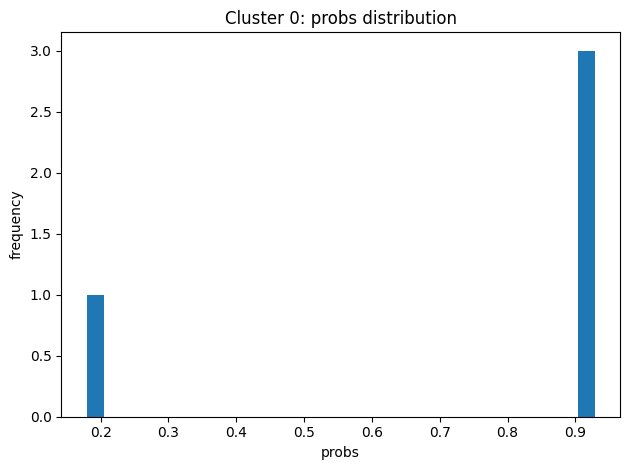

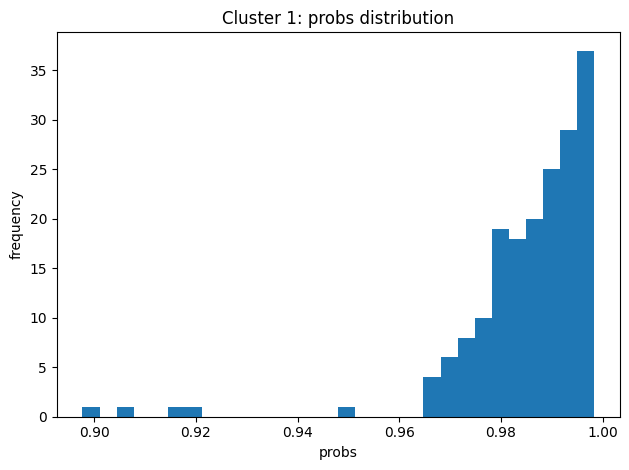

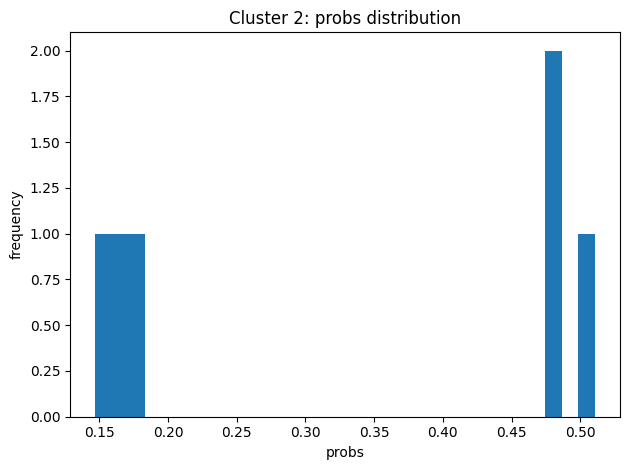

In [26]:
import pandas as pd
import matplotlib.pyplot as plt

# ① 데이터프레임(df)이 이미 로드되어 있다는 가정하에 진행합니다.
#    만약 CSV 등에서 불러와야 한다면, 예를 들면:
# df = pd.read_csv('your_data.csv')

# ——————————————————————————————
# 1) 클러스터별 preds == 1인 개수 집계
total_per_cluster = (
    novel_df
    .groupby('cluster')
    .size()
    .reset_index(name='total_count')
)

# 2) 클러스터별 preds == 1인 개수
preds1_per_cluster = (
    novel_df[novel_df['preds'] == 1]
    .groupby('cluster')
    .size()
    .reset_index(name='count_preds_1')
)

# 3) 합치고 비율 계산
stats = pd.merge(total_per_cluster, preds1_per_cluster, on='cluster', how='left')
stats['count_preds_1'] = stats['count_preds_1'].fillna(0).astype(int)
stats['ratio_preds_1'] = stats['count_preds_1'] / stats['total_count']

print("클러스터별 preds == 1 개수 및 비율:")
print(stats)


# ——————————————————————————————
# 2) 클러스터별 probs 히스토그램
for cluster_id in sorted(novel_df['cluster'].unique()):
    plt.figure()
    plt.hist(novel_df.loc[novel_df['cluster'] == cluster_id, 'probs'], bins=30)
    plt.title(f'Cluster {cluster_id}: probs distribution')
    plt.xlabel('probs')
    plt.ylabel('frequency')
    plt.tight_layout()
    plt.show()
